In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import re
from collections import Counter
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
import traceback


# Set plotting style
plt.style.use('ggplot')
sns.set(font_scale=1.2)

# Download NLTK resources (uncomment if needed)
# nltk.download('stopwords')
# nltk.download('punkt')


In [4]:
file_path = '/Users/yuhngtan/Desktop/Project Webscraper/glassdoor_healthcare_jobs_detailed_20250401_220726.csv'

## 1. Function: Load and Clean

In [5]:
def load_and_clean_data(file_path):
    """
    Load and clean the Glassdoor healthcare jobs dataset
    """
    # Load the dataset
    df = pd.read_csv(file_path)
    print(f"Original dataset shape: {df.shape}")
    
    # Cleaning steps
    # 1. Handle missing values
    print(f"\nMissing values before cleaning:\n{df.isnull().sum()}")
    
    # 1.5 Split company and rating
    def split_company_rating(company_str):
        if pd.isna(company_str) or not isinstance(company_str, str):
            return company_str, np.nan
        
        # Extract rating using regex - looks for a number at the end of the string
        rating_pattern = r'(.*?)\s+(\d+\.\d+)$'
        match = re.search(rating_pattern, company_str)
        
        if match:
            company_name = match.group(1).strip()
            rating_val = float(match.group(2))
            return company_name, rating_val
        else:
            return company_str, np.nan
    
    # Apply the split function
    company_data = df['company'].apply(split_company_rating)
    df['company'] = [x[0] for x in company_data]
    df['rating'] = [x[1] for x in company_data]
    
    # The rest of your original code continues here...
    # Fill missing ratings with NaN (to be excluded from analysis)
    df['rating'] = pd.to_numeric(df['rating'], errors='coerce')
    
    
    # 2. Clean and convert salary data
    def clean_salary(salary_str):
        if pd.isna(salary_str) or salary_str == '' or not isinstance(salary_str, str):
            return np.nan, np.nan, np.nan
        
        # Extract salary range using improved regex
        # This pattern captures the estimate source (Glassdoor Est., Employer Est., etc.)
        pattern = r'(\$[\d,.]+[KM]?)(?:\s*-\s*(\$[\d,.]+[KM]?))?(?:\s+(?:a\s)?(year|month|hour|week))?(?:\s+\((.*?)\))?'
        match = re.search(pattern, salary_str)
        
        if not match:
            return np.nan, np.nan, np.nan
        
        min_salary, max_salary, explicit_period, source = match.groups()
        
        # Process salary values
        def convert_salary(salary):
            if not salary:
                return np.nan
            
            # Remove $ and commas
            salary = salary.replace('$', '').replace(',', '')
            
            # Convert K and M suffixes
            multiplier = 1
            if salary.endswith('K'):
                multiplier = 1000
                salary = salary[:-1]
            elif salary.endswith('M'):
                multiplier = 1000000
                salary = salary[:-1]
            
            try:
                return float(salary) * multiplier
            except:
                return np.nan
        
        min_val = convert_salary(min_salary)
        max_val = convert_salary(max_salary) if max_salary else min_val
        
        # Determine period based on both explicit period and source
        period = explicit_period
        
        # If no explicit period is provided, infer from the source and amount
        if not period:
            # If it's Employer Est. and the values are small (< 20K), likely monthly
            if source and 'Employer Est.' in source and min_val < 20000:
                period = 'month'
            # If it's Glassdoor Est. or values are typical annual ranges, assume yearly
            else:
                period = 'year'
        
        # Standardize to annual salary
        if period:
            period = period.lower()
            if period == 'hour':
                min_val = min_val * 40 * 52 if not np.isnan(min_val) else np.nan
                max_val = max_val * 40 * 52 if not np.isnan(max_val) else np.nan
            elif period == 'week':
                min_val = min_val * 52 if not np.isnan(min_val) else np.nan
                max_val = max_val * 52 if not np.isnan(max_val) else np.nan
            elif period == 'month':
                min_val = min_val * 12 if not np.isnan(min_val) else np.nan
                max_val = max_val * 12 if not np.isnan(max_val) else np.nan
        
        avg_salary = (min_val + max_val) / 2 if not (np.isnan(min_val) or np.isnan(max_val)) else np.nan
        
        return min_val, max_val, avg_salary
    
    # Apply salary cleaning function
    salary_data = df['salary'].apply(clean_salary)
    df['min_salary'] = [x[0] for x in salary_data]
    df['max_salary'] = [x[1] for x in salary_data]
    df['avg_salary'] = [x[2] for x in salary_data]
    
    # 3. Convert date columns
    df['posted_date'] = pd.to_datetime(df['posted_date'], errors='coerce')
    df['scrape_date'] = pd.to_datetime(df['scrape_date'], errors='coerce')
    
    # 4. Extract state from location
    def extract_state(location):
        if pd.isna(location) or not isinstance(location, str):
            return np.nan
        
        # Check if there's a state code at the end (2 capital letters)
        state_match = re.search(r',\s*([A-Z]{2})$', location)
        if state_match:
            return state_match.group(1)
        return np.nan
    
    df['state'] = df['location'].apply(extract_state)
    
    # 5. Standardize job titles
    def standardize_title(title):
        if pd.isna(title) or not isinstance(title, str):
            return np.nan
        
        # Convert to lowercase and remove extra spaces
        title = re.sub(r'\s+', ' ', title.lower().strip())
        
        # Extract key healthcare roles
        nurse_pattern = r'(registered nurse|rn|lpn|nurse practitioner|np|clinical nurse|nurse manager)'
        doctor_pattern = r'(physician|doctor|md|surgeon|cardiologist|neurologist|oncologist)'
        tech_pattern = r'(technician|technologist|tech|AI|programmer|developer|software|data)'
        admin_pattern = r'(administrator|manager|director|coordinator|supervisor)'
        assistant_pattern = r'(assistant|aide|cna|medical assistant)'
        therapist_pattern = r'(therapist|therapy|counselor|counseling|psychologist|social worker)'
        radiology_pattern = r'(radiologist|radiology|imaging|mri|ct|xray|x-ray|sonograph|ultrasound)'
        pharmacy_pattern = r'(pharmacist|pharmacy|pharm|pharmaceutic)'
        research_pattern = r'(scientist|researcher|research|lab|laboratory)'
        specialist_pattern = r'(specialist)'
        emergency_pattern = r'(paramedic|emt|emergency|ambulance)'
        nutrition_pattern = r'(dietitian|nutritionist|diet|nutrition)'
        finance_pattern = r'(finance|financial|billing|accounting|revenue)'
        engineering_pattern = r'(engineer|engineering)'
        executive_pattern = r'(executive|chief|ceo|cfo|cio|cto|director)'
        
        if re.search(nurse_pattern, title):
            role = 'Nursing'
        elif re.search(doctor_pattern, title):
            role = 'Physician'
        elif re.search(tech_pattern, title):
            role = 'Technology'
        elif re.search(admin_pattern, title):
            role = 'Administrative'
        elif re.search(assistant_pattern, title):
            role = 'Assistant'
        elif re.search(therapist_pattern, title):
            role = 'Therapy'
        elif re.search(radiology_pattern, title):
            role = 'Radiology'
        elif re.search(pharmacy_pattern, title):
            role = 'Pharmacy'
        elif re.search(research_pattern, title):
            role = 'Research'
        elif re.search(emergency_pattern, title):
            role = 'Emergency'
        elif re.search(nutrition_pattern, title):
            role = 'Nutrition'
        elif re.search(finance_pattern, title):
            role = 'Finance'
        elif re.search(engineering_pattern, title):
            role = 'Engineering'
        elif re.search(executive_pattern, title):
            role = 'Executive'
        elif re.search(specialist_pattern, title):
            role = 'Specialist'
        else:
            role = 'Other'
        
        return role
    
    df['job_category'] = df['title'].apply(standardize_title)
    
    # 6. Remove duplicate entries
    df_deduped = df.drop_duplicates()
    print(f"Removed {df.shape[0] - df_deduped.shape[0]} duplicate rows")
    df = df_deduped
    
    # Final cleaned dataset
    print(f"\nCleaned dataset shape: {df.shape}")
    print(f"Missing values after cleaning:\n{df.isnull().sum()}")
    
    return df

In [6]:
df = load_and_clean_data(file_path)
df.head()

Original dataset shape: (628, 7)

Missing values before cleaning:
company        0
title          0
rating         0
location       0
posted_date    0
scrape_date    0
salary         0
dtype: int64
Removed 0 duplicate rows

Cleaned dataset shape: (628, 12)
Missing values after cleaning:
company           0
title             0
rating            0
location          0
posted_date     628
scrape_date       0
salary            0
min_salary      486
max_salary      486
avg_salary      486
state           628
job_category      0
dtype: int64


/var/folders/32/yk92ldn108zgrfqm8r2sdlkm0000gn/T/ipykernel_22637/1951152229.py:115: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['posted_date'] = pd.to_datetime(df['posted_date'], errors='coerce')


,company,title,rating,location,posted_date,scrape_date,salary,min_salary,max_salary,avg_salary,state,job_category
0,Doctor Anywhere,[SG] Clinic Assistant (Taman Jurong),3.0,Jurong West New Town,NaT,2025-04-01 21:40:05,Not Provided,NaN,NaN,NaN,NaN,Assistant
1,Agency for Integrated Care Pte Ltd,"Assistant Manager/Senior Executive, Partnershi...",3.6,Singapore,NaT,2025-04-01 21:40:07,Not Provided,NaN,NaN,NaN,NaN,Administrative
2,National University Hospital,Resident Physician (Palliative),3.7,Queenstown Estate,NaT,2025-04-01 21:40:08,$148K - $180K (Glassdoor Est.),148000.0,180000.0,164000.0,NaN,Physician
3,National Healthcare Group,Executive Assistant - 1 month,2.6,Singapore,NaT,2025-04-01 21:40:10,Not Provided,NaN,NaN,NaN,NaN,Assistant
4,SingHealth Group,"Senior / Executive (Centre Partnerships), A.L....",3.5,Singapore,NaT,2025-04-01 21:40:11,Not Provided,NaN,NaN,NaN,NaN,Radiology


In [7]:
selected_jobs = df[df['job_category'].isin(['Nursing'])]

## 2. Function: Salary Analysis

In [8]:
def salary_analysis(df, display_plots=True):
    """
    Perform comprehensive salary analysis with value labels on histograms
    
    Parameters:
    -----------
    df : pandas.DataFrame
        DataFrame containing job data with salary information
    display_plots : bool
        Whether to display the plots in addition to saving them (default: True)
    """
    import matplotlib.pyplot as plt
    import seaborn as sns
    import numpy as np
    
    print("\n----- SALARY ANALYSIS -----\n")
    # Filter out rows without salary information
    salary_df = df.dropna(subset=['avg_salary'])
    print(f"Number of jobs with salary information: {salary_df.shape[0]}")
    
    # Overall salary statistics
    print("\nOverall Salary Statistics:")
    salary_stats = salary_df[['min_salary', 'max_salary', 'avg_salary']].describe()
    print(salary_stats)
    
    # Salary distribution by job category
    print("\nSalary by Job Category:")
    category_salary = salary_df.groupby('job_category')['avg_salary'].agg(['count', 'mean', 'median', 'min', 'max'])
    category_salary = category_salary.sort_values('mean', ascending=False)
    print(category_salary)
    
    # Salary distribution by state (top 10 states by job count)
    print("\nSalary by State (Top 10 states by job count):")
    top_states = df['state'].value_counts().head(10).index
    state_salary = salary_df[salary_df['state'].isin(top_states)].groupby('state')['avg_salary'].agg(['count', 'mean', 'median', 'min', 'max'])
    state_salary = state_salary.sort_values('mean', ascending=False)
    print(state_salary)
    
    # Salary distribution by company (top 10 companies by job count)
    print("\nSalary by Company (Top 10 companies by job count):")
    top_companies = df['company'].value_counts().head(10).index
    company_salary = salary_df[salary_df['company'].isin(top_companies)].groupby('company')['avg_salary'].agg(['count', 'mean', 'median', 'min', 'max'])
    company_salary = company_salary.sort_values('mean', ascending=False)
    print(company_salary)
    
    # Create a list to store figure objects
    figures = []
    
    # Visualizations
    # 1. Overall salary distribution with value labels
    fig1 = plt.figure(figsize=(12, 6))
    figures.append(fig1)
    
    # Create histogram with specific number of bins for better labeling
    bins = 30
    hist, bin_edges = np.histogram(salary_df['avg_salary'], bins=bins)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    
    # Plot the histogram with KDE
    ax = sns.histplot(salary_df['avg_salary'], kde=True, bins=bins)
    
    # Add value labels to bins with non-zero counts
    for i, (count, x) in enumerate(zip(hist, bin_centers)):
        if count > 0:
            # Only label bars with significant counts to avoid overcrowding
            if count > max(hist) * 0.05:
                ax.text(x, count + (max(hist) * 0.02), f'{count}', 
                       ha='center', va='bottom', fontsize=9, rotation=0,
                       bbox={'facecolor': 'white', 'alpha': 0.7, 'pad': 1})
    
    plt.title('Distribution of Average Annual Salaries', fontsize=14)
    plt.xlabel('Annual Salary (USD)', fontsize=12)
    plt.ylabel('Count', fontsize=12)
    
    # Add median and mean lines with labels
    median_salary = salary_df['avg_salary'].median()
    mean_salary = salary_df['avg_salary'].mean()
    
    plt.axvline(x=median_salary, color='r', linestyle='--', alpha=0.7)
    plt.axvline(x=mean_salary, color='g', linestyle='-', alpha=0.7)
    
    # Add text labels for median and mean
    plt.text(median_salary + (bin_edges[-1] - bin_edges[0])*0.01, max(hist)*0.95, 
             f'Median: ${median_salary/1000:.1f}K', color='r', fontweight='bold')
    plt.text(mean_salary + (bin_edges[-1] - bin_edges[0])*0.01, max(hist)*0.85, 
             f'Mean: ${mean_salary/1000:.1f}K', color='g', fontweight='bold')
    
    plt.grid(axis='y', linestyle='--', alpha=0.3)
    plt.tight_layout()
    plt.savefig('salary_distribution.png', dpi=300, bbox_inches='tight')
    if not display_plots:
        plt.close(fig1)
    
    # 2. Salary by job category boxplot with min/max labels
    fig2 = plt.figure(figsize=(16, 10))
    figures.append(fig2)
    ax = sns.boxplot(x='job_category', y='avg_salary', data=salary_df)
    plt.title('Salary Distribution by Job Category', fontsize=16)
    plt.xlabel('Job Category', fontsize=14)
    plt.ylabel('Annual Salary (USD)', fontsize=14)
    plt.xticks(rotation=45, ha='right', fontsize=12)
    
    # Add min and max labels to each box
    # Get category statistics 
    category_stats = salary_df.groupby('job_category')['avg_salary'].agg(['min', 'max']).reset_index()
    
    # Add min/max annotations for each category
    for i, category in enumerate(ax.get_xticklabels()):
        category_name = category.get_text()
        if category_name in category_stats['job_category'].values:
            # Get min and max values for this category
            category_data = category_stats[category_stats['job_category'] == category_name]
            min_val = category_data['min'].values[0]
            max_val = category_data['max'].values[0]
            
            # Format values for display (K for thousands)
            min_text = f"${min_val/1000:.1f}K" if min_val >= 1000 else f"${min_val:.0f}"
            max_text = f"${max_val/1000:.1f}K" if max_val >= 1000 else f"${max_val:.0f}"
            
            # Add min label at the bottom
            ax.text(i, min_val, min_text, ha='center', va='top', fontweight='bold', 
                    color='red', fontsize=10, bbox={'facecolor': 'white', 'alpha': 0.8, 'pad': 3})
            
            # Add max label at the top
            ax.text(i, max_val, max_text, ha='center', va='bottom', fontweight='bold', 
                    color='green', fontsize=10, bbox={'facecolor': 'white', 'alpha': 0.8, 'pad': 3})
    
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.savefig('salary_by_category.png', dpi=300, bbox_inches='tight')
    if not display_plots:
        plt.close(fig2)
    
    # Display all plots if requested
    if display_plots:
        plt.show()
    
    return category_salary, state_salary, figures

## 3. Function: Job Market Trend

In [28]:
def job_market_trends(df):
    """
    Analyze job market trends (skipping time series analysis)
    """
    import matplotlib.pyplot as plt
    import pandas as pd
    
    print("\n----- JOB MARKET TRENDS -----\n")
    
    # Skip time series analysis entirely to avoid issues
    print("Note: Time series analysis has been skipped.")
    
    # Create empty Series for monthly_counts to maintain return value structure
    monthly_counts = pd.Series()
    
    # 2. Job distribution by category
    category_counts = df['job_category'].value_counts()
    
    # Check if category_counts is empty
    if not category_counts.empty:
        print("\nJob Distribution by Category:")
        print(category_counts)
        
        # Plot job distribution by category
        plt.figure(figsize=(12, 7))
        category_counts.plot(kind='bar')
        plt.title('Job Distribution by Category')
        plt.xlabel('Job Category')
        plt.ylabel('Number of Job Postings')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.savefig('jobs_by_category.png')
    else:
        print("Warning: No job category data available.")
    
    # 3. Job distribution by company
    company_counts = df['company'].value_counts().head(10)
    
    # Check if company_counts is empty
    if not company_counts.empty:
        print("\nTop 10 Companies by Job Count:")
        print(company_counts)
        
        # Plot job distribution by company
        plt.figure(figsize=(14, 7))
        company_counts.plot(kind='bar')
        plt.title('Top 10 Companies by Job Count')
        plt.xlabel('Company')
        plt.ylabel('Number of Job Postings')
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.savefig('jobs_by_company.png')
    else:
        print("Warning: No company data available.")
    
    return monthly_counts, category_counts, company_counts

## 4. Function: Job title analysis

In [10]:
def job_title_analysis(df):
    """
    Analyze job titles to identify trends and common roles
    """
    print("\n----- JOB TITLE ANALYSIS -----\n")
    
    # 1. Extract and analyze keywords from job titles
    def extract_keywords(title):
        if pd.isna(title) or not isinstance(title, str):
            return []
        
        # Tokenize and clean the title
        tokens = re.findall(r'\b[A-Za-z]+\b', title.lower())
        
        # Remove stopwords
        stop_words = set(stopwords.words('english'))
        tokens = [token for token in tokens if token not in stop_words and len(token) > 2]
        
        return tokens
    
    all_keywords = []
    for title in df['title'].dropna():
        all_keywords.extend(extract_keywords(title))
    
    keyword_counts = Counter(all_keywords)
    
    print("Top 30 Job Title Keywords:")
    for word, count in keyword_counts.most_common(30):
        print(f"{word}: {count}")
    
    # 2. Identify common job title patterns
    def identify_pattern(title):
        if pd.isna(title) or not isinstance(title, str):
            return np.nan
        
        # Look for common patterns in job titles
        patterns = {
            'Senior': r'\b(senior|sr\.?)\b',
            'Junior': r'\b(junior|jr\.?|entry[\s-]level)\b',
            'Manager': r'\b(manager|director|lead|supervisor|head)\b',
            'Specialist': r'\b(specialist|coordinator)\b',
            'Remote': r'\b(remote|virtual|telehealth|telemed)\b',
            'Travel': r'\b(travel|traveler|traveling)\b',
            'Part-time': r'\b(part[\s-]time|prn)\b',
            'Contract': r'\b(contract|temporary|temp|locum)\b'
        }
        
        title_lower = title.lower()
        found_patterns = []
        
        for pattern_name, regex in patterns.items():
            if re.search(regex, title_lower):
                found_patterns.append(pattern_name)
        
        return found_patterns
    
    # Apply pattern identification
    df['title_patterns'] = df['title'].apply(identify_pattern)
    
    # Explode the patterns to count them
    pattern_df = df.explode('title_patterns')
    pattern_counts = pattern_df['title_patterns'].value_counts().dropna()
    
    print("\nCommon Job Title Patterns:")
    print(pattern_counts)
    
    # 3. Analyze job seniority
    seniority_map = {
        'Entry-level': lambda x: any(p == 'Junior' for p in x) if isinstance(x, list) else False,
        'Mid-level': lambda x: isinstance(x, list) and not any(p in ['Junior', 'Senior', 'Manager'] for p in x),
        'Senior': lambda x: any(p == 'Senior' for p in x) if isinstance(x, list) else False,
        'Management': lambda x: any(p == 'Manager' for p in x) if isinstance(x, list) else False
    }
    
    for level, condition in seniority_map.items():
        df[level] = df['title_patterns'].apply(condition)
    
    seniority_counts = {level: df[level].sum() for level in seniority_map.keys()}
    
    print("\nJob Seniority Distribution:")
    for level, count in seniority_counts.items():
        print(f"{level}: {count} ({count/len(df)*100:.2f}%)")
    
    # 4. Analyze job format
    format_counts = {
        'Remote': pattern_counts.get('Remote', 0),
        'Travel': pattern_counts.get('Travel', 0),
        'Part-time': pattern_counts.get('Part-time', 0),
        'Contract': pattern_counts.get('Contract', 0)
    }
    
    print("\nJob Format Distribution:")
    for format_type, count in format_counts.items():
        print(f"{format_type}: {count} ({count/len(df)*100:.2f}%)")
    
    # Visualizations
    # 1. Word cloud of job title keywords
    plt.figure(figsize=(12, 12))
    wordcloud = WordCloud(width=800, height=800, background_color='white', max_words=200, 
                         colormap='viridis', collocations=False).generate_from_frequencies(keyword_counts)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('Job Title Keywords', fontsize=20)
    plt.tight_layout()
    plt.savefig('job_title_wordcloud.png')
    
    # 2. Bar chart of common patterns
    plt.figure(figsize=(12, 7))
    pattern_counts.plot(kind='bar')
    plt.title('Common Job Title Patterns')
    plt.xlabel('Pattern')
    plt.ylabel('Count')
    plt.tight_layout()
    plt.savefig('job_title_patterns.png')
    
    # 3. Pie chart of job seniority
    plt.figure(figsize=(10, 10))
    plt.pie([seniority_counts[level] for level in seniority_map.keys()], 
            labels=[f"{level}\n({seniority_counts[level]/len(df)*100:.1f}%)" for level in seniority_map.keys()], 
            autopct='', startangle=90)
    plt.axis('equal')
    plt.title('Job Seniority Distribution')
    plt.tight_layout()
    plt.savefig('job_seniority_pie.png')
    
    # 4. Correlation between job category and seniority
    seniority_columns = list(seniority_map.keys())
    category_seniority = pd.DataFrame()
    
    for category in df['job_category'].dropna().unique():
        category_df = df[df['job_category'] == category]
        seniority_percentages = {level: category_df[level].mean() * 100 for level in seniority_columns}
        category_seniority[category] = pd.Series(seniority_percentages)
    
    plt.figure(figsize=(14, 8))
    category_seniority.T.plot(kind='bar', stacked=True)
    plt.title('Job Seniority Distribution by Category')
    plt.xlabel('Job Category')
    plt.ylabel('Percentage')
    plt.legend(title='Seniority Level')
    plt.tight_layout()
    plt.savefig('seniority_by_category.png')
    
    # 5. Correlation between job format and salary
    format_salary = pd.DataFrame(columns=['Format', 'AvgSalary'])
    
    for format_type in ['Remote', 'Travel', 'Part-time', 'Contract']:
        format_jobs = pattern_df[pattern_df['title_patterns'] == format_type]
        avg_salary = format_jobs['avg_salary'].mean()
        format_salary = pd.concat([format_salary, pd.DataFrame({'Format': [format_type], 'AvgSalary': [avg_salary]})], ignore_index=True)
    
    # Add 'Regular' (jobs not matching any special format)
    special_formats = pattern_df[pattern_df['title_patterns'].isin(['Remote', 'Travel', 'Part-time', 'Contract'])]['index'].unique()
    regular_jobs = df[~df.index.isin(special_formats)]
    avg_regular_salary = regular_jobs['avg_salary'].mean()
    format_salary = pd.concat([format_salary, pd.DataFrame({'Format': ['Regular'], 'AvgSalary': [avg_regular_salary]})], ignore_index=True)
    
    plt.figure(figsize=(12, 7))
    sns.barplot(x='Format', y='AvgSalary', data=format_salary.sort_values('AvgSalary', ascending=False))
    plt.title('Average Salary by Job Format')
    plt.xlabel('Job Format')
    plt.ylabel('Average Annual Salary (USD)')
    plt.tight_layout()
    plt.savefig('salary_by_format.png')
    
    return keyword_counts, pattern_counts, seniority_counts, format_counts

## 5. Function: Run Full Analyssis

Original dataset shape: (628, 7)

Missing values before cleaning:
company        0
title          0
rating         0
location       0
posted_date    0
scrape_date    0
salary         0
dtype: int64
Removed 0 duplicate rows

Cleaned dataset shape: (628, 12)
Missing values after cleaning:
company           0
title             0
rating            0
location          0
posted_date     628
scrape_date       0
salary            0
min_salary      486
max_salary      486
avg_salary      486
state           628
job_category      0
dtype: int64
Cleaned dataset saved to 'cleaned_healthcare_jobs.csv'

Starting salary analysis...

----- SALARY ANALYSIS -----

Number of jobs with salary information: 142

Overall Salary Statistics:
          min_salary     max_salary     avg_salary
count     142.000000     142.000000     142.000000
mean    90549.845070  125085.126761  107817.485915
std     70346.812116   87111.690455   78024.766172
min        10.000000      12.000000      11.000000
25%     36000.0000

/var/folders/32/yk92ldn108zgrfqm8r2sdlkm0000gn/T/ipykernel_22637/1951152229.py:115: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['posted_date'] = pd.to_datetime(df['posted_date'], errors='coerce')


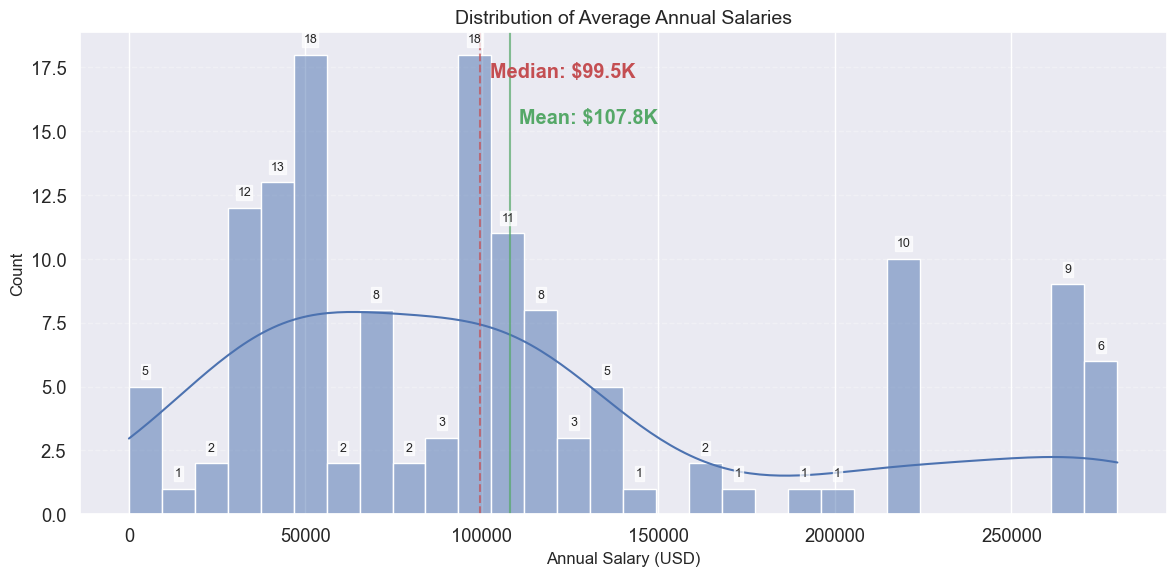

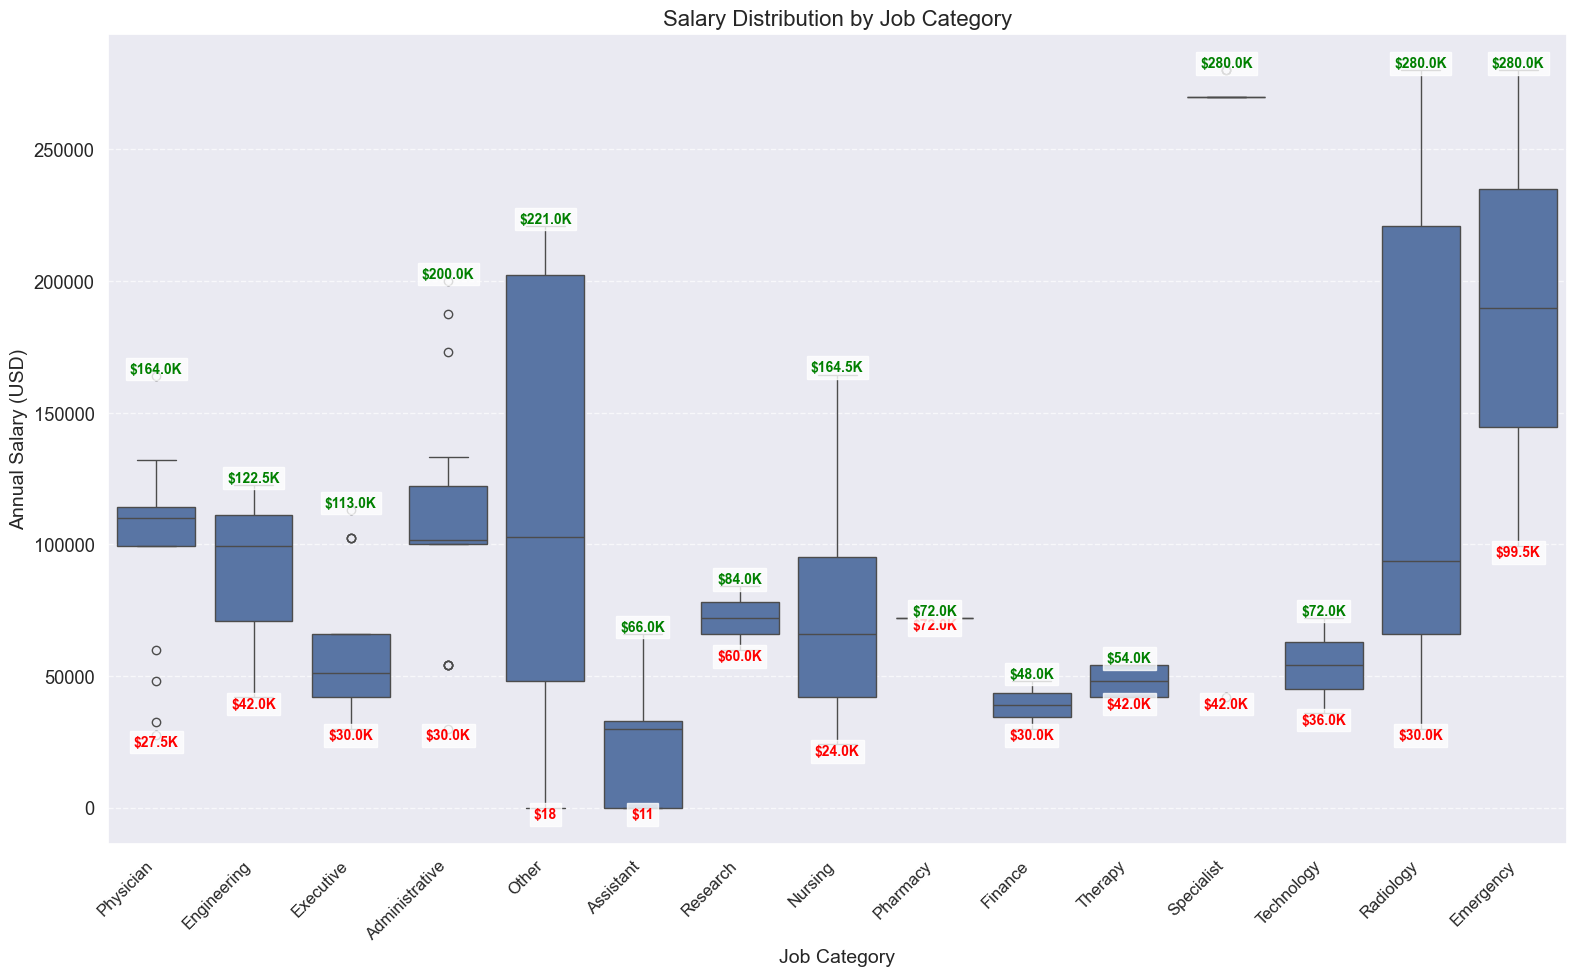

Salary analysis completed successfully.

Starting job market trends analysis...

----- JOB MARKET TRENDS -----

Note: Time series analysis has been skipped.

Job Distribution by Category:
job_category
Administrative    114
Executive         103
Other              93
Radiology          58
Nursing            51
Assistant          41
Physician          32
Technology         28
Therapy            26
Specialist         19
Research           18
Finance            13
Pharmacy           13
Engineering        11
Emergency           4
Nutrition           4
Name: count, dtype: int64

Top 10 Companies by Job Count:
company
SingHealth Group                                             192
National Healthcare Group                                     49
Tan Tock Seng Hospital                                        49
Woodlands Health                                              31
National University Hospital                                  27
National Healthcare Group Polyclinics                   

/var/folders/32/yk92ldn108zgrfqm8r2sdlkm0000gn/T/ipykernel_22637/2272662587.py:150: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  format_salary = pd.concat([format_salary, pd.DataFrame({'Format': [format_type], 'AvgSalary': [avg_salary]})], ignore_index=True)
Traceback (most recent call last):
  File "/Users/yuhngtan/Library/Python/3.11/lib/python/site-packages/pandas/core/indexes/base.py", line 3805, in get_loc
    return self._engine.get_loc(casted_key)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "index.pyx", line 167, in pandas._libs.index.IndexEngine.get_loc
  File "index.pyx", line 196, in pandas._libs.index.IndexEngine.get_loc
  File "pandas/_libs/hashtable_class_helper.pxi", line 7081, in pandas._libs.hashtable.PyObjectHashTab

Error in job title analysis: 'index'

Analysis complete. All visualizations have been saved as PNG files.


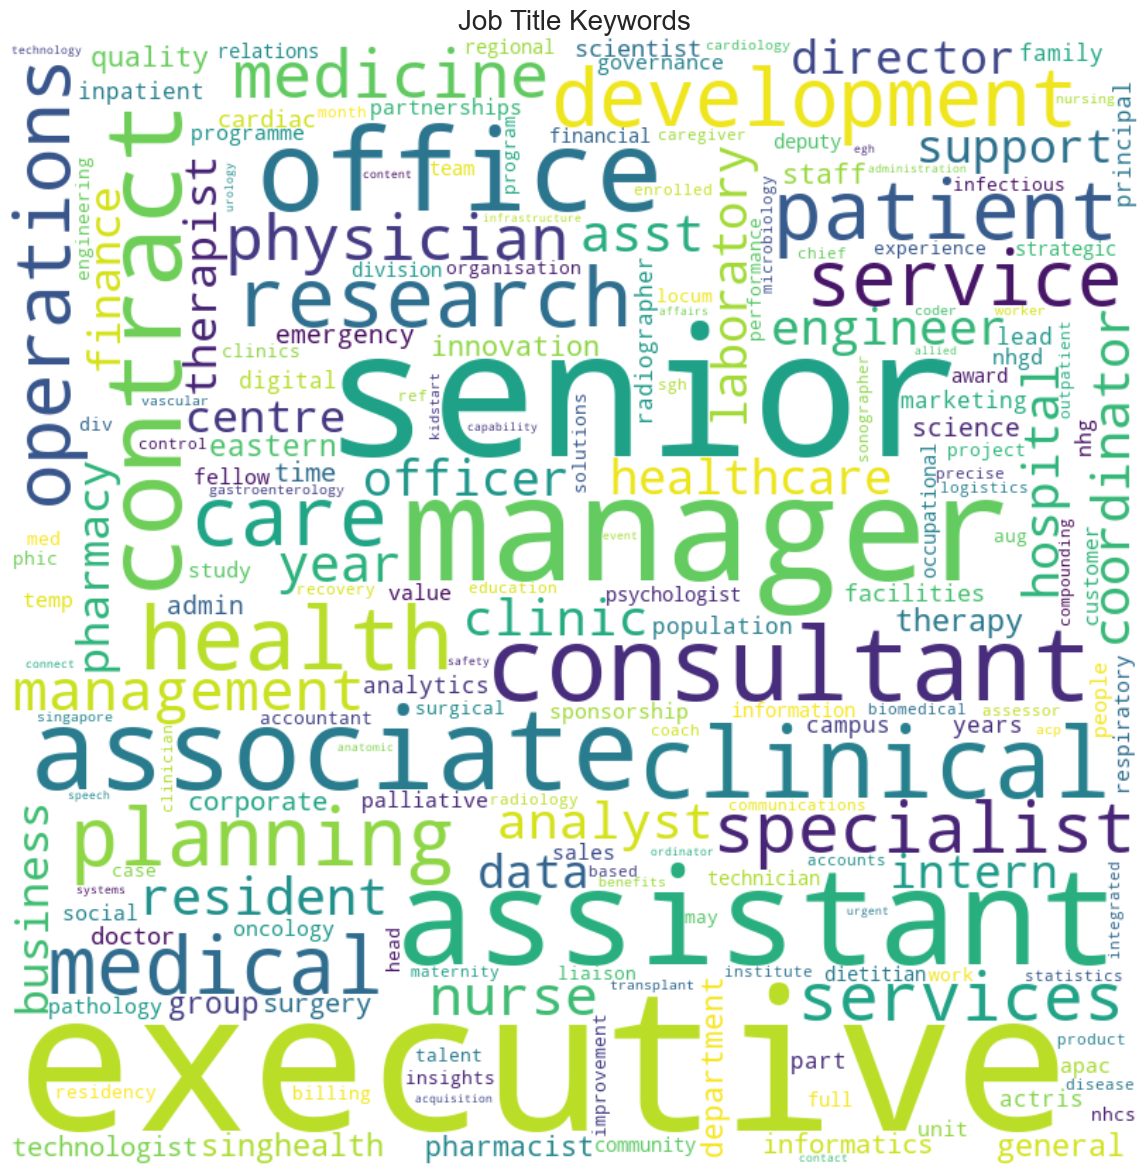

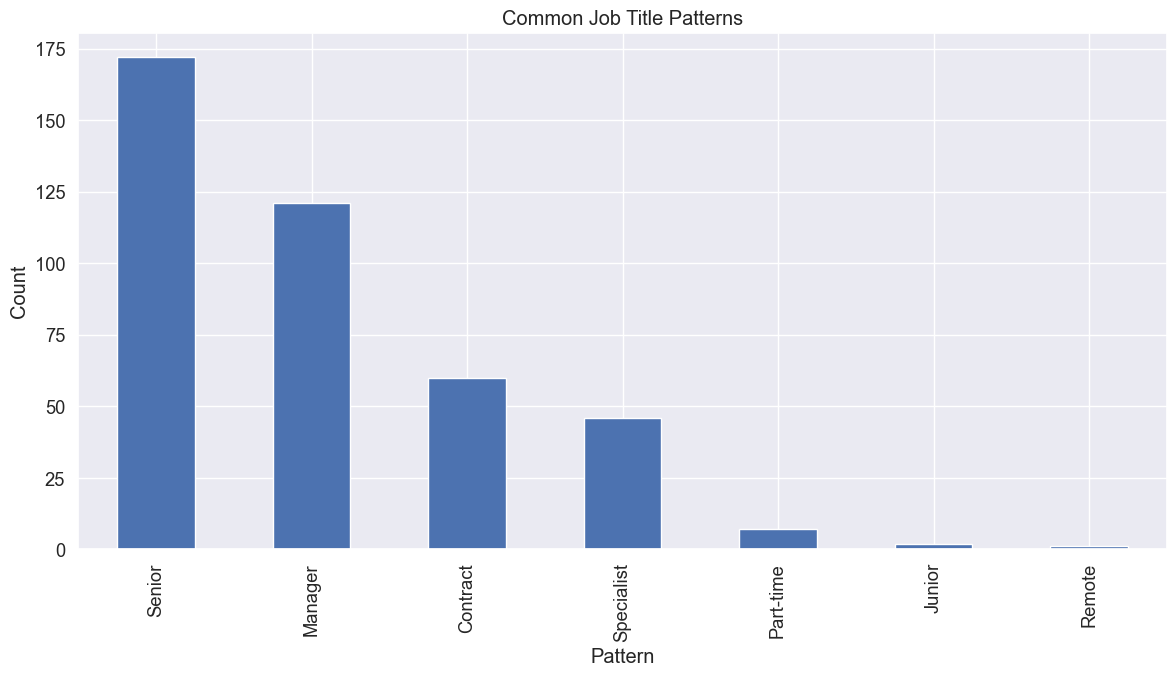

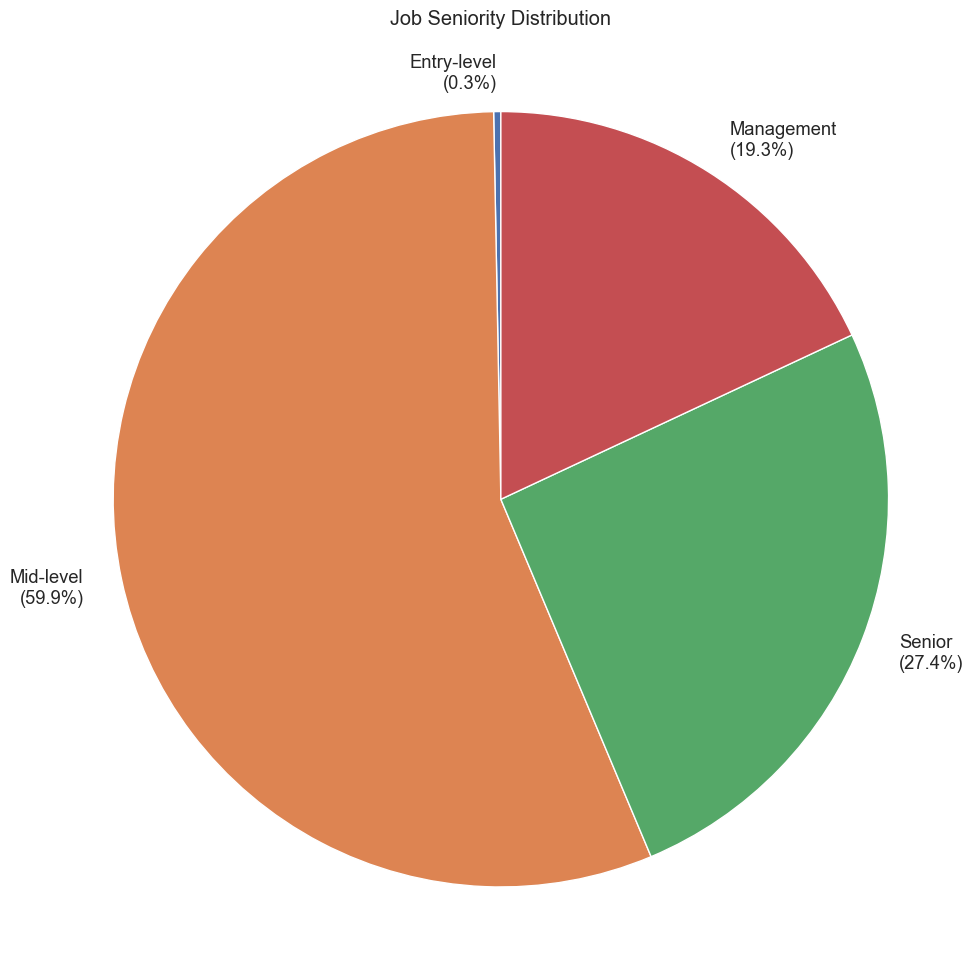

<Figure size 1400x800 with 0 Axes>

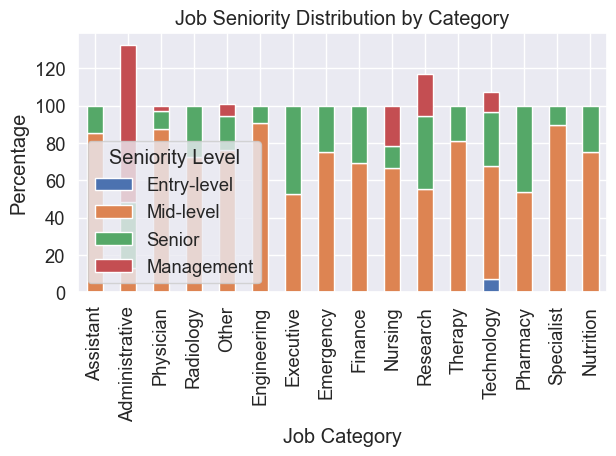

In [29]:
def main():
    """
    Main function to run the healthcare jobs analysis pipeline
    """

    
    try:
        # Load and clean data
        file_path = '/Users/yuhngtan/Desktop/Project Webscraper/glassdoor_healthcare_jobs_detailed_20250401_220726.csv'
        df = load_and_clean_data(file_path)
        
        if df.empty:
            print("Error: No data available after loading/cleaning.")
            return
        
        # Save the cleaned dataset
        df.to_csv('cleaned_healthcare_jobs.csv', index=False)
        print("Cleaned dataset saved to 'cleaned_healthcare_jobs.csv'")
        
        # Perform analyses with error handling
        try:
            print("\nStarting salary analysis...")
            salary_results = salary_analysis(df)
            print("Salary analysis completed successfully.")
        except Exception as e:
            print(f"Error in salary analysis: {e}")
            traceback.print_exc()
        
        try:
            print("\nStarting job market trends analysis...")
            # Ensure we close any previous plot
            plt.close('all')  
            job_market_results = job_market_trends(df)
            print("Job market trends analysis completed successfully.")
        except Exception as e:
            print(f"Error in job market trends analysis: {e}")
            traceback.print_exc()
        
        try:
            print("\nStarting job title analysis...")
            # Ensure we close any previous plot
            plt.close('all')
            job_title_results = job_title_analysis(df)
            print("Job title analysis completed successfully.")
        except Exception as e:
            print(f"Error in job title analysis: {e}")
            traceback.print_exc()
        
        print("\nAnalysis complete. All visualizations have been saved as PNG files.")
    
    except Exception as e:
        print(f"Error in main execution: {e}")
        traceback.print_exc()

if __name__ == "__main__":
    main()